In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [31]:
function get_quantiles(data, qvals)
    
    qvals = sort(qvals)
    ampvals = sort([data...], rev=true)
    cumsumvals = cumsum(ampvals)
    
    levels_array = []
    
    levels_array = [ampvals[argmin(abs.(cumsumvals .- q))] for q in qvals]
    quantiles_labels = ["$(x*100)\\%" for x in qvals]
    
    sort_ind = sortperm(levels_array)
    
    return levels_array[sort_ind], quantiles_labels[sort_ind]
end

get_quantiles (generic function with 1 method)

In [32]:
FPATH = "../../data/sampling_results/Benchmark-10/"

@load FPATH*"mcmc-summary-data.jld" data_save
data = data_save[1];

In [33]:
charges_n = data.ev_charge ./ maximum(data.ev_charge)
runind_n = data.ev_index ./ maximum(data.ev_index);

In [34]:
rind = 1:length(data.ev_charge)

1:828

In [35]:
charges_n[sortperm(charges_n)] .= 1:length(charges_n)
charges_n = charges_n ./ maximum(charges_n);
charges = data.ev_charge;

## Transversal Size: 

In [36]:
σ_x = data.μx_trsz
σ_y = data.μy_trsz

std_x = data.σx_trsz
std_y = data.σy_trsz;

In [37]:
xmin, xmax = 0.01, 0.25
xrange=range(xmin, stop = xmax,length=100)
yrange=range(xmin, stop = xmax,length=100)
xvals = [pdf(truncated(Normal(0.2, 0.04), 0.02, 0.25), x) for x in xrange]
yvals = [pdf(truncated(Normal(0.2, 0.04), 0.02, 0.25), y)  for y in yrange]
z = xvals*yvals';

In [49]:
quantiles_array = [0.0, 0.9, 0.95, 0.999, 1]

levels, level_labels = get_quantiles(z./sum(z), quantiles_array);

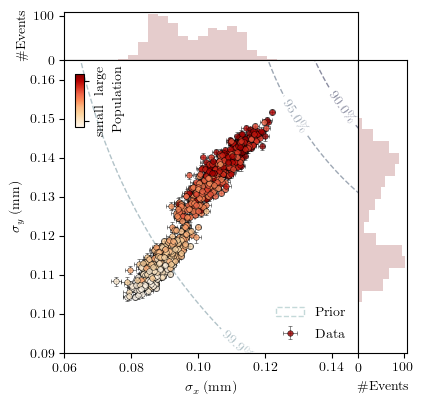

In [52]:
figsize = (4.429223744292238, 4.429223744292238)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)


colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]
cs = ax[2,1].contour(xrange, yrange, z./sum(z), levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 


label_1 = "Data"

errorbar_ind = rind[1]:1:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x[i] : false
    y_err = i in errorbar_ind ? std_y[i] : false
    ax[2,1].errorbar(σ_x[i], σ_y[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.8,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.15,0.62,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)
ax[2,1].legend(loc="lower right", framealpha=0.0)

bins_tmp = range(0.02, stop=0.165, length=50)
ax[1,1].hist(σ_x, bins=bins_tmp, color=plt.cm.OrRd(1.), alpha=0.20)
ax[2,2].hist(σ_y, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.), alpha=0.2)

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.06, 0.148)
ax[1,1].set_xlim(0.06, 0.148)
ax[2,1].set_ylim(0.09, 0.165)
ax[2,2].set_ylim(0.09, 0.165)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/tr-size-m-1.pdf", bbox_inches = "tight")

## Angular Spread: 

In [147]:
σ_x = data.μx_angspr
σ_y = data.μy_angspr

std_x = data.σx_angspr
std_y = data.σy_angspr;

In [153]:
xmin, xmax = 1., 8.
xrange=range(xmin, stop = xmax,length=100)
yrange=range(xmin, stop = xmax,length=100)
xvals = [pdf(Normal(4, 2), x) for x in xrange]
yvals = [pdf(Normal(4, 2), y)  for y in yrange]
z = xvals*yvals';

In [160]:
quantiles_array = [0.0, 0.05, 0.15, 0.5, 1]

levels, level_labels = get_quantiles(z./sum(z), quantiles_array);

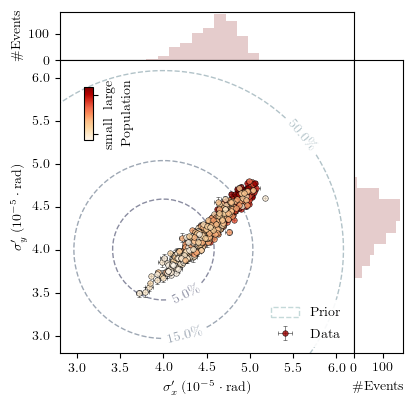

In [161]:
figsize = (4.429223744292238, 4.429223744292238)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]
cs = ax[2,1].contour(xrange, yrange, z./sum(z), levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 

label_1 = "Data"

errorbar_ind = rind[1]:3:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x[i] : false
    y_err = i in errorbar_ind ? std_y[i] : false
    ax[2,1].errorbar(σ_x[i], σ_y[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.8,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""

end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.18,0.59,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior LC")
# proxy3 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Greens(0.57), label="Posterior SC")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)
# ax[2,1].add_patch(proxy3)

bins_tmp = range(0.8, stop=7.2, length=50)
ax[1,1].hist(σ_x, bins=bins_tmp, color=plt.cm.OrRd(1.), alpha=0.20)
ax[2,2].hist(σ_y, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.), alpha=0.2)

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(2.8, 6.2)
ax[1,1].set_xlim(2.8, 6.2)
ax[2,1].set_ylim(2.8, 6.2)
ax[2,2].set_ylim(2.8, 6.2)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].legend(loc="lower right", framealpha=0.9, edgecolor=:white)

ax[2,1].set_xlabel(L"\sigma'_x \; (\mathrm{10^{-5} \cdot rad})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma'_y \; (\mathrm{10^{-5} \cdot rad})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")


fig.savefig("../../plots/ang-spread-m-1.pdf", bbox_inches = "tight")


## Emittance: 

In [122]:
em_x = data.μx_emitt
em_y = data.μy_emitt

std_x = data.σx_emitt
std_y = data.σy_emitt;

In [123]:
prior_emmitance_x = rand(Normal(0.2, 0.04), 10^7) .* rand(Normal(4, 2), 10^7) .* 10^-5 .* 1000 .* 426.0
prior_emmitance_y = rand(Normal(0.2, 0.04), 10^7) .* rand(Normal(4, 2), 10^7) .* 10^-5 .* 1000 .* 426.0

hist_em_tmp = fit(Histogram, (prior_emmitance_x,prior_emmitance_y),nbins=120)
hist_em_tmp = normalize(hist_em_tmp, mode=:pdf);

range_tmp = range(1.2*minimum(hist_em_tmp.weights), stop=maximum(hist_em_tmp.weights), length=10)[2:end]
colors_tmp = [plt.cm.bone_r(i) for i in range(0, stop=0.4, length=length(range_tmp))[2:end]];

In [145]:
quantiles_array = [0.0, 0.1, 0.2, 0.3, 0.50, 0.7, 1]

levels, level_labels = get_quantiles(hist_em_tmp.weights./sum(hist_em_tmp.weights), quantiles_array);

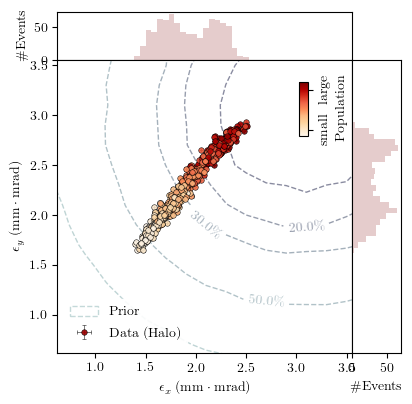

In [146]:
figsize = (4.429223744292238, 4.429223744292238)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# ax[2,1].contourf(midpoints(hist_em_tmp.edges[1]), midpoints(hist_em_tmp.edges[2]), hist_em_tmp.weights', levels=range_tmp, colors=colors_tmp, alpha=0.3, antialiased=true)
# colors_tmp = [plt.cm.bone_r(i) for i in range(0, stop=0.4, length=length(levels))[2:end]]
# cs = ax[2,1].contour(midpoints(hist_em_tmp.edges[1]), midpoints(hist_em_tmp.edges[2]), hist_em_tmp.weights', levels=levels, colors=colors_tmp, alpha=0.6, antialiased=true, linewidths=1.2, linestyles="dashed") 
# ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]

cs = ax[2,1].contour(
    midpoints(hist_em_tmp.edges[1]),
    midpoints(hist_em_tmp.edges[2]), 
    (hist_em_tmp.weights./sum(hist_em_tmp.weights))', 
    levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 


label_1 = "Data (Halo)"
label_2 = "Data (Core)"

errorbar_ind = rind[1]:3:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x[i] : false
    y_err = i in errorbar_ind ? std_y[i] : false
    ax[2,1].errorbar(em_x[i], em_y[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
cb2 = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="GnBu")
ax_ins_3 = fig.add_axes([0.67,0.6,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)

bins_tmp = range(0.7, stop=3.5, length=50)
ax[1,1].hist(em_x, bins=bins_tmp, color=plt.cm.OrRd(1.0), alpha=0.20)
ax[2,2].hist(em_y, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.0), alpha=0.20)

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.62, 3.55)
ax[1,1].set_xlim(0.62, 3.55)
ax[2,1].set_ylim(0.62, 3.55)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].legend(loc="lower left", framealpha=0.9, edgecolor=:white)

ax[2,2].set_ylim(0.62, 3.55)

ax[2,1].set_xlabel(L"\epsilon_x \; (\mathrm{mm \cdot mrad})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\epsilon_y \; (\mathrm{mm \cdot mrad})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/em-m-1.pdf", bbox_inches = "tight")

## Alignment: 

In [162]:
μx = data.μx_align
μy = data.μy_align;

In [163]:
fig, ax= plt.subplots(2,2, figsize=(6,6),)
fig.subplots_adjust(hspace=0.07, wspace=0.07)

label = "Mean + Std"

ax[1,1].scatter([μ[1] for μ in μx], [μ[1] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, label=label)
ax[1,2].scatter([μ[2] for μ in μx], [μ[2] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )
ax[2,1].scatter([μ[3] for μ in μx], [μ[3] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )
ax[2,2].scatter([μ[4] for μ in μx], [μ[4] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )

cb = ax[3].scatter(charges_n, charges_n, s=0.0, c=data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.79,0.77,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticks_position("top")

ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticks_position("top")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")

ax[1,1].text(0.04,0.91,"Cam. #1", transform=ax[1,1].transAxes)
ax[1,2].text(0.04,0.91,"Cam. #2", transform=ax[1,2].transAxes)
ax[2,1].text(0.04,0.91,"Cam. #3", transform=ax[2,1].transAxes)
ax[2,2].text(0.04,0.91,"Cam. #4", transform=ax[2,2].transAxes)

ax[1,1].set_xlim(-5,310)
ax[1,1].set_ylim(-5,310)

ax[1,2].set_xlim(-5,310)
ax[1,2].set_ylim(-5,310)

ax[2,1].set_xlim(-5,310)
ax[2,1].set_ylim(-5,310)

ax[2,2].set_xlim(-5,310)
ax[2,2].set_ylim(-5,310)
# ax[2,2].set_ylim(34.2,37)

ax[2,2].set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax[2,1].set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")

ax[1,1].set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")
ax[2,1].set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

Figure(PyObject <Figure size 600x600 with 5 Axes>)

PyObject Text(0, 0.5, '$\\mu_y \\; \\mathrm{(\\mu m)}$')

# Plot Quantiles

In [ ]:
xmin, xmax = -3, 3
xrange=range(xmin, stop = xmax,length=300)
yrange=range(xmin, stop = xmax,length=300)
xvals = [pdf(Normal(0, 1), x) for x in xrange]
yvals = [pdf(Normal(0, 1), y)  for y in yrange]
z = xvals*yvals';

In [ ]:
n_gaps = 10
levels = range(0, length = n_gaps,  stop=maximum(z))  
level_labels = map(x -> "$(round(x/maximum(z)*100, sigdigits=3))\\%", levels)

In [ ]:
fig, ax= plt.subplots(1,1)

cs = ax.contour(xrange, yrange, z, levels=levels, colors="red", ) 

ax.clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax.axhline([-1.])
ax.axhline([1.])

In [ ]:
ampvals = [z...] ./ sum(z)
ampvals = sort(ampvals, rev=true)
cumsumvals = cumsum(ampvals)

quantiles_array = [0.0, 0.68, 0.9, 0.94, 0.95, 0.997, 1]

levels_array = []
for q in quantiles_array
    push!(levels_array, ampvals[argmin(abs.(cumsumvals .- q))])
end

In [ ]:
function get_quantiles(data, qvals)
    
    ampvals = sort([data...], rev=true)
    cumsumvals = cumsum(ampvals)
    
    levels_array = []
    for q in qvals
        push!(levels_array, ampvals[argmin(abs.(cumsumvals .- q))])
    end
    
    quantiles_labels = map(x -> "$(x*100)\\%", qvals)
    
    return levels_array, quantiles_labels
end

In [ ]:
levels_array

In [ ]:
quantiles_labels = map(x -> "$(x*100)\\%", quantiles_array)

In [ ]:
sort(levels_array)

In [ ]:
fig, ax= plt.subplots(1,1)

cs = ax.contour(xrange, yrange, z./ sum(z), levels=sort(levels_array),  )  #levels=levels_array,

ax.set_xlim(1,2)
ax.set_ylim(1,2)

ax.clabel(cs, fmt = Dict(zip(levels_array, quantiles_labels)), inline = true, inline_spacing=2);